In [2]:
%load_ext autoreload
%autoreload 2

import torch
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Extract Features and Compute Density

In [4]:
# torchvision computed features
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm
from tqdm import tqdm

device = 'cuda'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Standard normalization for pre-trained models
])

# Load dataset
dataset = ImageFolder(YOUR_DATASET_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

##### timm #####
##### has to be 0.5.4 
model_name = "vit_base_patch16_224" 
model = timm.create_model(model_name, pretrained=True, num_classes=0).to(device)
model.eval()


features_list = []

# Extract features
with torch.no_grad():
    for data in tqdm(dataloader):
        inputs, _ = data
        inputs = inputs.to(device)
        features = model(inputs)
        features = features.view(features.size(0), -1)  # Flatten the features
        features_list.append(features.detach().cpu())

# Concatenate all features
all_features = torch.cat(features_list, dim=0)

print(all_features.shape)  # [number_of_images, 2048]

100%|██████████| 3945/3945 [07:21<00:00,  8.94it/s]


torch.Size([126228, 768])


In [5]:
def compute_distances(row_features, col_features, num_gpus, rank, col_batch_size):
    assert 0 <= rank < num_gpus
    num_cols = col_features.shape[0]
    num_batches = ((num_cols - 1) // col_batch_size // num_gpus + 1) * num_gpus
    col_batches = torch.nn.functional.pad(col_features, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
    dist_batches = []
    for col_batch in col_batches[rank :: num_gpus]:
        dist_batch = torch.cdist(row_features.unsqueeze(0), col_batch.unsqueeze(0))[0]
        for src in range(num_gpus):
            dist_broadcast = dist_batch.clone()
            if num_gpus > 1:
                torch.distributed.broadcast(dist_broadcast, src=src)
            dist_batches.append(dist_broadcast.cpu() if rank == 0 else None)
    return torch.cat(dist_batches, dim=1)[:, :num_cols] if rank == 0 else None


all_features = all_features.cuda()
dists = compute_distances(all_features, all_features, num_gpus=1, rank=0, col_batch_size=10000)

In [33]:
# K = 10
K = 20
top_k_dists = torch.topk(dists, k=K+1, largest=False)
avg_top_k = top_k_dists.values[:, 1:].mean(dim=1)

volumes = avg_top_k ** 1
density = 1. / volumes
density = len(density) * density / density.sum() # normalize and scale

torch.save(density, 'metrics/church_density_vit_timm0.5.4.pt')

N = len(density)
print(torch.sort(avg_top_k))
print(torch.sort(avg_top_k).values[N // 2])

In [38]:
N = len(density)
print(torch.sort(density))
print(torch.sort(density).values[int(0.1 * N)])
print(torch.sort(density).values[int(0.2 * N)])
print(torch.sort(density).values[int(0.3 * N)])
print(torch.sort(density).values[int(0.4 * N)])
print(torch.sort(density).values[int(0.5 * N)])
print(torch.sort(density).values[int(0.6 * N)])
print(torch.sort(density).values[int(0.7 * N)])
print(torch.sort(density).values[int(0.8 * N)])
print(torch.sort(density).values[int(0.9 * N)])

torch.return_types.sort(
values=tensor([ 0.5862,  0.5915,  0.5987,  ..., 11.9501, 11.9501, 11.9501]),
indices=tensor([110375, 125041,  57063,  ...,  16355,  25388,  86656]))
tensor(0.8299)
tensor(0.8805)
tensor(0.9189)
tensor(0.9527)
tensor(0.9850)
tensor(1.0182)
tensor(1.0569)
tensor(1.1056)
tensor(1.1804)


## Train a Density Estimator

In [39]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = self.fc4(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(in_channels, out_channels)
        self.fc2 = nn.Linear(out_channels, out_channels)

    def forward(self, x):
        identity = x
        out = nn.ReLU()(self.fc1(x))
        out = self.fc2(out)
        out += identity
        out = nn.ReLU()(out)
        return out

In [40]:
X = torch.tensor(all_features, dtype=torch.float32).cuda()  # Replace YOUR_DATA_HERE with your dataset
y = torch.tensor(density, dtype=torch.float32).unsqueeze(1).cuda()  # Assuming labels are in the same order as samples

# Split data into training and validation sets (80-20 split)
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

/tmp/ipykernel_15478/69250024.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(all_features, dtype=torch.float32).cuda()  # Replace YOUR_DATA_HERE with your dataset
/tmp/ipykernel_15478/69250024.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(density, dtype=torch.float32).unsqueeze(1).cuda()  # Assuming labels are in the same order as samples


In [41]:
model = FNN().cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_X.size(0)
    
    avg_train_loss = total_loss / train_size
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    avg_val_loss = val_loss / val_size
    print(f"Validation Loss: {avg_val_loss:.4f}\n")

Epoch [1/100], Loss: 0.0196
Validation Loss: 0.0128

Epoch [2/100], Loss: 0.0086
Validation Loss: 0.0053

Epoch [3/100], Loss: 0.0079
Validation Loss: 0.0032

Epoch [4/100], Loss: 0.0060
Validation Loss: 0.0025

Epoch [5/100], Loss: 0.0064
Validation Loss: 0.0039

Epoch [6/100], Loss: 0.0049
Validation Loss: 0.0055

Epoch [7/100], Loss: 0.0044
Validation Loss: 0.0033

Epoch [8/100], Loss: 0.0047
Validation Loss: 0.0038

Epoch [9/100], Loss: 0.0040
Validation Loss: 0.0053

Epoch [10/100], Loss: 0.0047
Validation Loss: 0.0025

Epoch [11/100], Loss: 0.0038
Validation Loss: 0.0040

Epoch [12/100], Loss: 0.0032
Validation Loss: 0.0021

Epoch [13/100], Loss: 0.0046
Validation Loss: 0.0023

Epoch [14/100], Loss: 0.0021
Validation Loss: 0.0021

Epoch [15/100], Loss: 0.0032
Validation Loss: 0.0019

Epoch [16/100], Loss: 0.0030
Validation Loss: 0.0069

Epoch [17/100], Loss: 0.0028
Validation Loss: 0.0078

Epoch [18/100], Loss: 0.0037
Validation Loss: 0.0021

Epoch [19/100], Loss: 0.0021
Validati

In [42]:
torch.save(model.state_dict(), 'metrics/church_score_fnn_vit_timm0.5.4.pt')

## Density-Based Perturbation

In [ ]:
import pickle
import copy
import legacy
import dnnlib
import torch

import matplotlib.pyplot as plt
import numpy as np


network_pkl = YOUR_PATH_TO_YOUR_PRETRAINED_MODEL  # StyleGAN2-FFHQ-1024
with dnnlib.util.open_url(network_pkl, verbose=True) as f:
    network_dict = legacy.load_network_pkl(f)
    if 'pretrained' in network_pkl:
        G = network_dict['G_ema'].to('cuda')
        D = network_dict['D'].to('cuda')
        G.eval()
        D.eval()
    else:
        pass

In [3]:
import torchvision.transforms as transforms
from torchvision.models import inception_v3
import timm
from training.inception import ViTExtractor

inception_model = ViTExtractor(device='cuda')

def process_imgs(imgs):
    lo, hi = -1, 1
    imgs = np.asarray(imgs, dtype=np.float32)
    imgs = (imgs - lo) * (255 / (hi - lo))
    imgs = np.rint(imgs).clip(0, 255).astype(np.uint8)
    return imgs

def run_G(z, c=None, sync=False):
    return G(z=z, c=c, noise_mode='const'), None

def run_D(img, c=None, sync=False):
    return D(img, c)

def get_feat(imgs):
    return inception_model(imgs)
    
def get_score(imgs):
    with torch.no_grad():
        imgs_feats = get_feat(imgs).view(imgs.size(0), -1)
        return scorer(imgs_feats)
    
def get_real_score(imgs):
    with torch.no_grad():
        imgs_feats = get_feat(imgs).view(imgs.size(0), -1)
    dists = compute_distances(imgs_feats, feats, num_gpus=1, rank=0, col_batch_size=10000)
    top_d = torch.topk(dists, k=10, largest=False)
    return top_d.values.mean(dim=1)


In [4]:
from training.attacks import PGDAttack_ViT

attack = PGDAttack_ViT('cuda', inception=inception_model, epsilon=0.1, k=10, alpha=0.025)

/scratch/cvlab/home/shuli/released_repos/Pseudo-Diversity/training/attacks.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.scorer.load_state_dict(torch.load('/scra

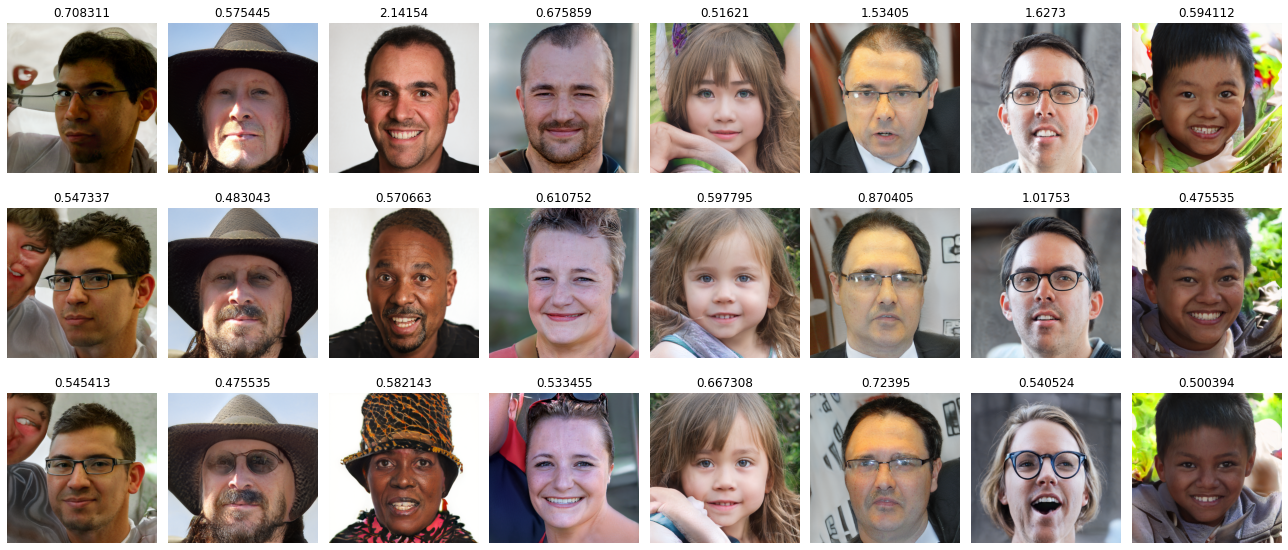

In [10]:
import training.attacks as attacks

z = torch.randn([8, 512], device='cuda')
imgs = G(z=z, c=None)
scores = attack.get_score(imgs)

z_pert_1 = attack(z, None, run_G=run_G, sync=False, reverse=True)
imgs_pert_1 = G(z=z_pert_1, c=None)
scores_pert_1 = attack.get_score(imgs_pert_1)
z_pert_2 = attack(z, None, run_G=run_G, sync=False)
imgs_pert_2 = G(z=z_pert_2, c=None)
scores_pert_2 = attack.get_score(imgs_pert_2)



fig, ax = plt.subplots(ncols=8, nrows=3, sharex='all', sharey='all', figsize=(18, 8))
for i in range(8):
    ax[0, i].imshow(process_imgs(imgs_pert_1[i].cpu().permute(1, 2, 0)))
    ax[0, i].axis('off')
    ax[0, i].set_title(f'{scores_pert_1[i].item():.6}')
    ax[1, i].imshow(process_imgs(imgs[i].cpu().permute(1, 2, 0)))
    ax[1, i].axis('off')
    ax[1, i].set_title(f'{scores[i].item():.6}')
    ax[2, i].imshow(process_imgs(imgs_pert_2[i].cpu().permute(1, 2, 0)))
    ax[2, i].axis('off')
    ax[2, i].set_title(f'{scores_pert_2[i].item():.6}')
plt.tight_layout()